# SYNGENTA CROP CHALLENGE

# Crop Yield Prediction

##### The challenge is to understand and classify crop yield based on two set of environmental features; heat and drought. We have modelled both separately.

## Importing and exploring data

In [1]:
import pandas as pd

performance_data = pd.read_csv('performance_data.csv')
submission_template = pd.read_csv('submission_template.csv')
weather_data = pd.read_csv('weather_data.csv')

In [2]:
performance_data.head()

,HYBRID_ID,ENV_ID,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,PLANT_DATE,HARVEST_DATE,...,ENV_YIELD_STD,ELEVATION,CLAY,SILT,SAND,AWC,PH,OM,CEC,KSAT
0,H2782,Env_1,0,0,107.9577,2008,49.5,-98.0,2008-05-06,2008-11-03,...,7.591866,870.65,22.7,23.0,54.5,18.65,7.2,6.1,24.2,9.4
1,H2782,Env_2,0,0,85.7498,2008,49.3,-98.1,2008-05-14,2008-10-22,...,7.184953,942.41,22.7,22.0,55.8,18.75,7.3,6.9,25.2,10.2
2,H2240,Env_3,0,0,74.6116,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9
3,H1527,Env_3,0,0,83.8191,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9
4,H1369,Env_3,0,0,81.7917,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9


In [3]:
# Extract average weather metrics for every ENV_ID
weather_grouped = weather_data.groupby(by='ENV_ID').mean()
weather_grouped = weather_grouped.drop('DAY_NUM', axis='columns')

# Join dataframes on 'ENV_ID'
joined_df = performance_data.join(weather_grouped,on='ENV_ID')


## Binning function

In [4]:
factor_df = joined_df[['LONG', 'LAT', 'PREC', 'TMAX', 'TMIN']].drop_duplicates()
#determine min, mean, max
#segment factor from 1 to 4

def factor_seg(df, factor):
    min_ = factor_df[factor].min()
    max_ = factor_df[factor].max()
    mean_ = factor_df[factor].mean()
    #binning
    diff = (max_ - min_)/4
    b_l = list()
    for x in range(len(df)):
        temp = 0
        if df.iloc[x][factor] < (min_ + diff):
            temp = 1
        elif df.iloc[x][factor] < (min_ + 2*diff):
            temp = 2
        elif df.iloc[x][factor] < (min_ + 3*diff):
            temp = 3
        else:
            temp = 4
        b_l.append(temp)
    df.insert(loc=0, column=factor + '_binning', value=b_l)
    return df
test_df = factor_seg(factor_df, 'PREC')
#test_df
#test_df.loc[:, 'PREC_binning']

## Folium map with popup markers for every coordinate pair

In [5]:
#folium map
#For every coordinate pair: a popup shows values for 'PREC', 'IRR', 'ELEVATION', 'TMAX', 'TMIN'
import folium
m = folium.Map(location=[39, -96], zoom_start=5, tiles='Stamen Terrain')
folium_data = joined_df[['LONG', 'LAT', 'PREC','IRRIGATION', 'ELEVATION', 'TMAX', 'TMIN']].drop_duplicates()
folium
for x in range(len(folium_data)):
    folium.Marker([folium_data.iloc[x]['LAT'], folium_data.iloc[x]['LONG']], popup=(f"""Prec: {folium_data.iloc[x]['PREC']:.2f} IRR: {folium_data.iloc[x]['IRRIGATION']} Elev: {folium_data.iloc[x]['ELEVATION']:.0f} Tmax: {folium_data.iloc[x]['TMAX']:.2f} Tmin: {folium_data.iloc[x]['TMIN']:.2f}""")).add_to(m)
m


ModuleNotFoundError: No module named 'folium'

## Correlation heatmap
There are no strong correlations between weather conditions and yield if we look at the aggregated data. We can conclude we'll have to go one level deeper and do the analysis on every specific Hybrid_ID

In [6]:
# Import modules
import seaborn as sns
import numpy as np

# Prepare dataframe to redo correlation matrix
joined_df_drop = joined_df.drop(['HYBRID_ID','ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD'],axis='columns')
corr_matrix_joined = joined_df_drop.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_joined,cmap='BuGn')
top_5 = corr_matrix_joined['YIELD'].sort_values(ascending=False).iloc[1:6]
bottom_5 = corr_matrix_joined['YIELD'].sort_values(ascending=True).iloc[0:5]
print(top_5,bottom_5)

HYBRID_MG    0.219539
YEAR         0.208669
ENV_MG       0.162916
SRAD         0.161162
ELEVATION    0.154716
Name: YIELD, dtype: float64 OM     -0.163030
LONG   -0.141509
SWE    -0.115704
LAT    -0.103775
SAND   -0.073778
Name: YIELD, dtype: float64


## Joining performance and weather data

In [7]:
#Group data by crop id
weather_data_grouped_mean = weather_data.groupby(by='ENV_ID').mean()
weather_data_grouped_std = weather_data.groupby(by='ENV_ID').std()
weather_data_grouped = weather_data_grouped_mean.join(weather_data_grouped_std,
                                                      lsuffix='_AVG',
                                                     rsuffix='_STD')
weather_data_grouped = weather_data_grouped.drop('DAY_NUM_AVG',axis=1)
weather_data_grouped.head()

,DAYL_AVG,PREC_AVG,SRAD_AVG,SWE_AVG,TMAX_AVG,TMIN_AVG,VP_AVG,DAY_NUM_STD,DAYL_STD,PREC_STD,SRAD_STD,SWE_STD,TMAX_STD,TMIN_STD,VP_STD
ENV_ID,,,,,,,,,,,,,,,
Env_1,43200.000043,1.684932,276.111781,11.167123,8.093151,-3.256164,630.356164,105.510663,10075.200862,4.544882,131.085275,16.046875,14.926959,13.574307,535.634711
Env_10,43200.946768,3.079452,294.978630,19.868493,12.095890,2.241096,874.191781,105.510663,8183.382184,5.974924,134.977729,31.810984,11.625704,9.839269,559.526111
Env_100,43200.000070,2.901370,296.714521,20.679452,12.616438,0.632877,820.054795,105.510663,8795.413435,7.152662,119.593751,30.413609,12.877466,12.410814,614.102577
Env_1000,43200.946854,2.000000,352.368219,0.997260,18.323288,2.883562,824.876712,105.510663,6955.702533,6.970897,111.010912,2.447805,11.374718,10.219944,674.104452
Env_1001,43200.946854,2.561644,341.681097,2.443836,17.701370,2.924658,862.246575,105.510663,6955.702533,8.697269,112.386846,5.729262,11.039508,10.119774,629.404388


## Differentiating between heat and stress variables

In [8]:
joined_df = performance_data.join(weather_data_grouped,on='ENV_ID')
joined_df.head()
joined_df.columns

heat_stress_df = joined_df[['HYBRID_ID','ENV_ID','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','YIELD']]
drought_stress_df = joined_df[['HYBRID_ID','ENV_ID','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC','YIELD']]

# Linear Regression Predictions of Yield
### Grouping by Env to create new Linear Regression by Enviroment instead of Crop
Linear Regressions with the original data are not very representative as they repeat the same information for every Hybrid with the same enviroment data, instead the next 3 set of linear regressions look to predict the Enviroment Yield by establishing coefficients that can be applied to any particular set of conditions in any enviroment

In [9]:
#Converting dataframes to create linear regressions based only on enviroments
heat_stress_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD']]
drought_stress_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

heat_stress_env=heat_stress_env.drop_duplicates(subset=None, keep='first', inplace=False)
heat_stress_env=heat_stress_env.reset_index(level=0, drop=True)
# print(heat_stress_env)
print('HeatStressLen>',heat_stress_env.index)

drought_stress_env=drought_stress_env.drop_duplicates(subset=None, keep='first', inplace=False)
drought_stress_env=drought_stress_env.reset_index(level=0, drop=True)
# print(heat_stress_env)
print('DroughtStressLen>',drought_stress_env.index)

HeatStressLen> RangeIndex(start=0, stop=1560, step=1)
DroughtStressLen> RangeIndex(start=0, stop=1560, step=1)


## The following linear regressions represent the last iterations done after replacing different variables in each set to reduce the predicted error
SQMEAN ERROR serves as a measure of accuracy of the predicted yield in the test data, each iteration aims to reduce this value by considering the coefficients impact, the p value (less than 0.25) and the multicolinearity of the model

# HEAT LR 

In [10]:
import statsmodels.api as sm

trainheat_env=heat_stress_env.loc[:400]
testheat_env=heat_stress_env.loc[401:]
testheat_env=testheat_env[['ENV_ID','ENV_YIELD_MEAN','TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD', 'DAYL_AVG', 'DAYL_STD',
       'SRAD_AVG', 'SRAD_STD']]



features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD']
X = trainheat_env[features_]
y = trainheat_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns

#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testheat_env['TMAX_AVG']=testheat_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testheat_env['TMAX_STD']=testheat_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testheat_env['TMIN_AVG']=testheat_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testheat_env['TMIN_STD']=testheat_env['TMIN_STD'].apply (lambda x: coeff_ * x )

testheatreg_env=testheat_env[['TMAX_AVG', 'TMAX_STD', 'TMIN_AVG', 'TMIN_STD']]
real_=testheat_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testheatreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
error_=(real_-regress_)**2
print(" ")
print('sqmeanerror',error_.mean()**0.5)
# print('sqstderror',error_.std()**0.5)
heat_error_=error_.mean()**0.5
hreal_=real_
hregress_=regress_
hrvsa_=pd.concat([hreal_,hregress_], axis=1, sort=False)
hrvsa_.columns=["Actual","Regression"]

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3311.7646
Date:               2018-12-02 10:05 BIC:                3327.7404
No. Observations:   401              Log-Likelihood:     -1651.9  
Df Model:           4                F-statistic:        5425.    
Df Residuals:       397              Prob (F-statistic): 0.00     
R-squared:          0.982            Scale:              223.85   
--------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
TMAX_AVG      2.1037     0.5767   3.6478   0.0003    0.9699   3.2374
TMAX_STD      2.1553     1.9356   1.1135   0.2662   -1.6500   5.9606
TMIN_AVG      5.7322     0.8525   6.7239   0.0000    4.0562   7.4082
TMIN_STD      4.1380     1.8688   2.2142   0.0274    0.4639   7.8120

### Coefficients used for Heat Linear Regression Prediction of Enviroment Yield:


In [11]:
heat_coeff=tc
print("HeatSqrMeanError->",float(heat_error_))
heat_coeff

HeatSqrMeanError-> 37.47336766241544


,TMAX_AVG,TMAX_STD,TMIN_AVG,TMIN_STD
0,2.103662,2.155283,5.732214,4.137954


# DROUGHT LR

In [12]:
traindr_env=drought_stress_env.loc[:400]
testdr_env=drought_stress_env.loc[401:]
testdr_env=testdr_env[['ENV_ID','ENV_YIELD_MEAN','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

#REMOVING VP due to low coeff

features_=['PREC_AVG','PREC_STD','KSAT','AWC']
X = traindr_env[features_]
y = traindr_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
tc.columns

#Test coefficients with test data

coeff_=tc['PREC_AVG']
testdr_env['PREC_AVG']=testdr_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testdr_env['PREC_STD']=testdr_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['KSAT']
testdr_env['KSAT']=testdr_env['KSAT'].apply (lambda x: coeff_ * x )
coeff_=tc['AWC']
testdr_env['AWC']=testdr_env['AWC'].apply (lambda x: coeff_ * x )
testdrreg_env=testdr_env[['PREC_AVG','PREC_STD','KSAT','AWC']]
real_=testdr_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testdrreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])
error_=(real_-regress_)**2
print('sqmeanerror',error_.mean()**0.5)
# print('sqstderror',error_.std()**0.5)
drought_sqerror_=error_.mean()**0.5
dreal_=real_
dregress_=regress_
drvsa_=pd.concat([dreal_,dregress_], axis=1, sort=False)
drvsa_.columns=["Actual","Regression"]


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.977    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3403.6910
Date:               2018-12-02 10:05 BIC:                3419.6668
No. Observations:   401              Log-Likelihood:     -1697.8  
Df Model:           4                F-statistic:        4293.    
Df Residuals:       397              Prob (F-statistic): 0.00     
R-squared:          0.977            Scale:              281.52   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
PREC_AVG   -3.4617     1.4986   -2.3099   0.0214   -6.4079   -0.5155
PREC_STD    5.7836     0.8061    7.1748   0.0000    4.1989    7.3684
KSAT        3.5621     0.4047    8.8025   0.0000    2.7665    4.3576
AWC         3.1812     0.1914   16.6218   0.0000    2.8049    3.5574

## Coefficients used for Drought Linear Regression Prediction of Enviroment Yield:

In [13]:
drought_coeff=tc
print("Drought SqMeanError->",float(drought_sqerror_))
drought_coeff

Drought SqMeanError-> 26.160085806409413


,PREC_AVG,PREC_STD,KSAT,AWC
0,-3.461698,5.783615,3.56207,3.181174


# HEAT+DROUGHT LR

In [14]:
hd_env = joined_df[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]

#Converting dataframes to create linear regressions based only on enviroments

hd_env=hd_env.drop_duplicates(subset=None, keep='first', inplace=False)
hd_env=hd_env.reset_index(level=0, drop=True)

print('HeatDroughtStressLen>',hd_env.index)

HeatDroughtStressLen> RangeIndex(start=0, stop=1560, step=1)


In [15]:
trainhd_env=hd_env.loc[:400]
testhd_env=hd_env.loc[401:]
testhd_env=testhd_env[['ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD','TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD','IRRIGATION','PREC_AVG','PREC_STD','KSAT',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]


features_=['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
        'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD','SWE_AVG','SWE_STD','VP_AVG','VP_STD']
X = trainhd_env[features_]
y = trainhd_env["ENV_YIELD_MEAN"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary2())

coeff_df=pd.DataFrame(model.params)
print(coeff_df)
tc=coeff_df.transpose()
hdelements_=tc.columns
tc.columns

#Test coefficients with test data

coeff_=tc['TMAX_AVG']
testhd_env['TMAX_AVG']=testhd_env['TMAX_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMAX_STD']
testhd_env['TMAX_STD']=testhd_env['TMAX_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_AVG']
testhd_env['TMIN_AVG']=testhd_env['TMIN_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['TMIN_STD']
testhd_env['TMIN_STD']=testhd_env['TMIN_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_AVG']
testhd_env['SRAD_AVG']=testhd_env['SRAD_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SRAD_STD']
testhd_env['SRAD_STD']=testhd_env['SRAD_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_AVG']
testhd_env['PREC_AVG']=testhd_env['PREC_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['PREC_STD']
testhd_env['PREC_STD']=testhd_env['PREC_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_AVG']
testhd_env['VP_AVG']=testhd_env['VP_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['VP_STD']
testhd_env['VP_STD']=testhd_env['VP_STD'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_AVG']
testhd_env['SWE_AVG']=testhd_env['SWE_AVG'].apply (lambda x: coeff_ * x )
coeff_=tc['SWE_STD']
testhd_env['SWE_STD']=testhd_env['SWE_STD'].apply (lambda x: coeff_ * x )


testhdreg_env=testhd_env[['TMAX_AVG','TMAX_STD','TMIN_AVG','TMIN_STD',
                           'SRAD_AVG','SRAD_STD','PREC_AVG','PREC_STD',
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD']]


real_=testhd_env["ENV_YIELD_MEAN"]
regress_=[]
regress_=list(testhdreg_env.sum(1))
regress_=pd.DataFrame(regress_, columns=['YIELDREG'])
real_=pd.DataFrame(list(real_), columns=['YIELDREG'])

error_=(real_-regress_)**2

print('sqmeanerror',error_.mean()**0.5)
# print('sqstderror',error_.std()**0.5)
hd_sqerror_=error_.mean()**0.5
hdreal_=real_
hdregress_=regress_
hdrvsa_=pd.concat([hdreal_,hdregress_], axis=1, sort=False)
hdrvsa_.columns=["Actual","Regression"]

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: ENV_YIELD_MEAN   AIC:                3286.5338
Date:               2018-12-02 10:05 BIC:                3334.4613
No. Observations:   401              Log-Likelihood:     -1631.3  
Df Model:           12               F-statistic:        1967.    
Df Residuals:       389              Prob (F-statistic): 0.00     
R-squared:          0.984            Scale:              206.13   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
TMAX_AVG   -1.4537     1.3086   -1.1109   0.2673   -4.0264    1.1191
TMAX_STD    7.6210     2.6134    2.9162   0.0037    2.4829   12.7590
TMIN_AVG   14.1189     2.5097    5.6257   0.0000    9.1846   19.0531
TMIN_STD    4.9720     2.4043    2.0680   0.0393    0.2450    9.6990

## Coefficients used for Heat+Drought Linear Regression Prediction of Enviroment Yield:

In [16]:
hd_coeff=tc
print("Heat+Drought sqMeanError ->",float(hd_sqerror_))
hd_coeff

Heat+Drought sqMeanError -> 29.819601260494142


,TMAX_AVG,TMAX_STD,TMIN_AVG,TMIN_STD,SRAD_AVG,SRAD_STD,PREC_AVG,PREC_STD,SWE_AVG,SWE_STD,VP_AVG,VP_STD
0,-1.453651,7.620979,14.118853,4.971993,0.214189,-0.238371,8.071271,-0.426228,-0.815425,0.485474,-0.102216,-0.016457


## Linear Regressions Coefficients and Errors comparisons

In [17]:
print("Heat Variables + Coefficients")
print(heat_coeff)
print("Heat SqMeanError ->",float(heat_error_))
print(" ")
print(" ")
print("Drought Variables + Coefficients")
print(drought_coeff)
print("Drought SqMeanError ->",float(drought_sqerror_))
print(" ")
print(" ")
print("Heat&Drought Variables + Coefficients")
print(hd_coeff)
print("Heat+Drought SqMeanError ->",float(hd_sqerror_))

Heat Variables + Coefficients
   TMAX_AVG  TMAX_STD  TMIN_AVG  TMIN_STD
0  2.103662  2.155283  5.732214  4.137954
Heat SqMeanError -> 37.47336766241544
 
 
Drought Variables + Coefficients
   PREC_AVG  PREC_STD     KSAT       AWC
0 -3.461698  5.783615  3.56207  3.181174
Drought SqMeanError -> 26.160085806409413
 
 
Heat&Drought Variables + Coefficients
   TMAX_AVG  TMAX_STD   TMIN_AVG  TMIN_STD  SRAD_AVG  SRAD_STD  PREC_AVG  \
0 -1.453651  7.620979  14.118853  4.971993  0.214189 -0.238371  8.071271   

   PREC_STD   SWE_AVG   SWE_STD    VP_AVG    VP_STD  
0 -0.426228 -0.815425  0.485474 -0.102216 -0.016457  
Heat+Drought SqMeanError -> 29.819601260494142


### As it can be seen, the linear regression with the best error (less is better) is the one that only considers drought factors), in order to verify that, previous visualizations comparisons can help:

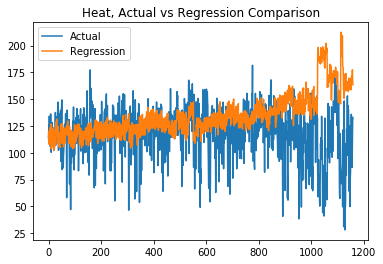

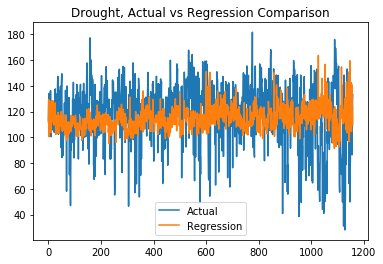

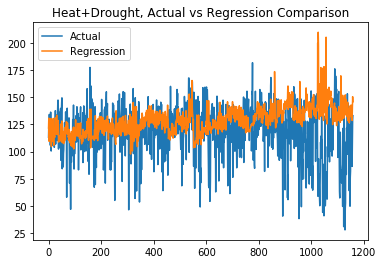

In [18]:
hrvsa_.plot(title='Heat, Actual vs Regression Comparison')
drvsa_.plot(title='Drought, Actual vs Regression Comparison')
hdrvsa_.plot(title='Heat+Drought, Actual vs Regression Comparison')

Drought Regression is the best fit and is consistent with the measured sqMeanError, however, we can see that there are certain data points that cannot be accurate predicted and therefore we decided to build more complex models with other methods

# Heat stress variables

YIELD       1.000000
SRAD_AVG    0.161162
TMAX_AVG    0.081646
TMIN_AVG    0.016498
TMIN_STD    0.014625
DAYL_AVG    0.003500
TMAX_STD   -0.064415
DAYL_STD   -0.116823
SRAD_STD   -0.160375
Name: YIELD, dtype: float64


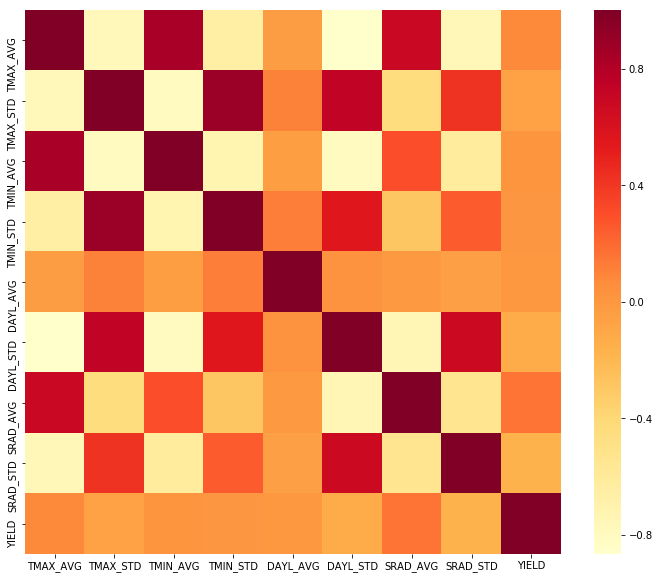

In [19]:
# Heat stress variables to yield correlation
# Import modules
import seaborn as sns
import numpy as np

# Prepare dataframe to redo correlation matrix
heat_stress_df_drop = heat_stress_df.drop(['HYBRID_ID','ENV_ID'],axis='columns')
corr_matrix_heat = heat_stress_df_drop.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_heat,cmap='YlOrRd')

print(corr_matrix_heat['YIELD'].sort_values(ascending=False))
#corr_matrix_heat['YIELD'].sort_values(ascending=True)

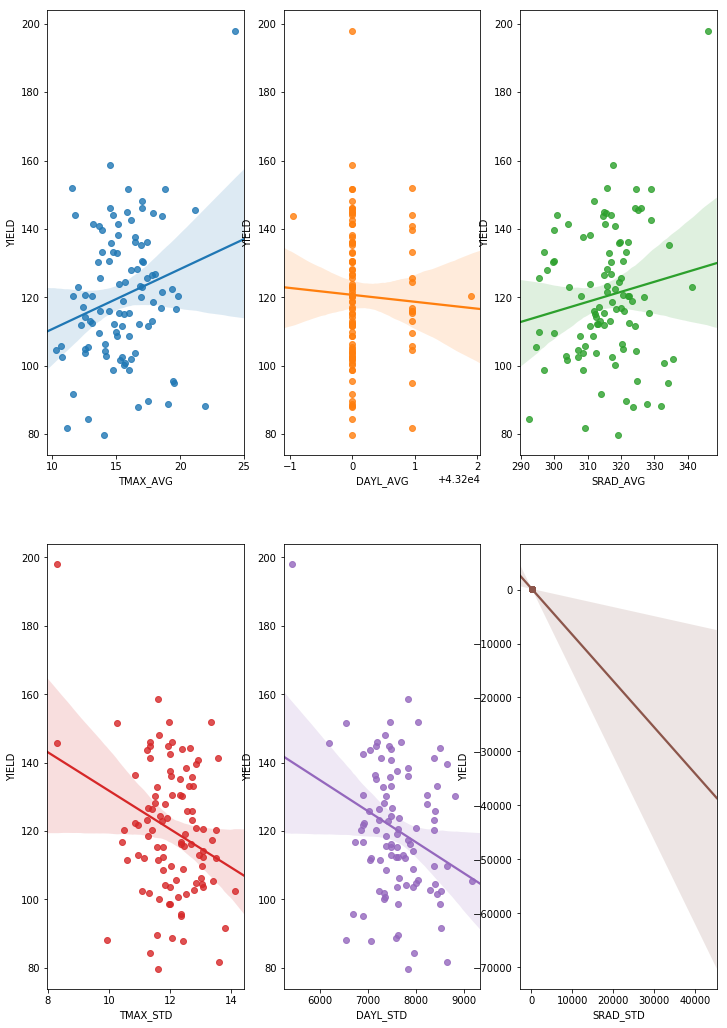

In [20]:
heat_stress_features_list = ['TMAX_AVG','DAYL_AVG','SRAD_AVG', 'TMAX_STD', 'DAYL_STD','SRAD_STD', 'SRAD_STD']
heat_stress_df_sample = heat_stress_df.sample(100)
#heat_stress_df_drop = df[heat_stress_features_list]
#heat_stress_features = [x for x in heat_stress_features_list]

fig, ax = plt.subplots(round(len(heat_stress_features_list) / 3), 3, figsize = (12, 18))

for i, ax in enumerate(fig.axes):
    if i < len(heat_stress_features_list) - 1:
        sns.regplot(x=heat_stress_features_list[i],y='YIELD', data=heat_stress_df_sample, ax=ax)

# Drought stress variables

YIELD       1.000000
PREC_STD    0.094834
VP_STD      0.061880
AWC         0.024275
PREC_AVG    0.005352
VP_AVG     -0.025146
KSAT       -0.028893
SWE_STD    -0.106854
SWE_AVG    -0.115704
Name: YIELD, dtype: float64


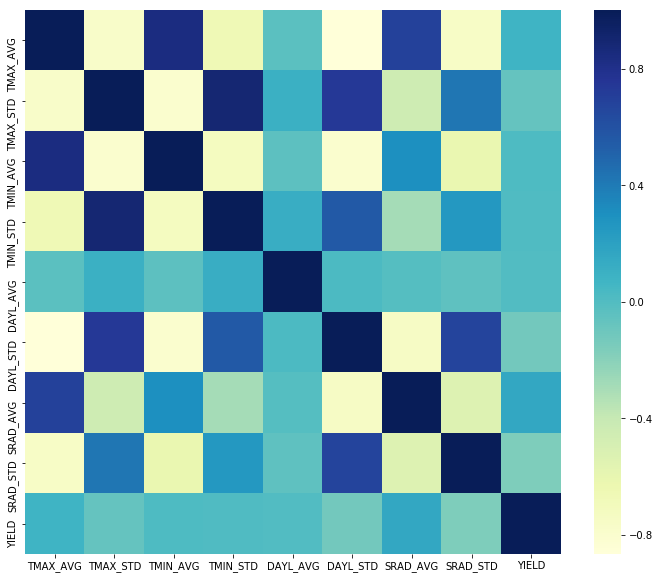

In [21]:
# Drought stress variables to yield correlation
# Import modules
import seaborn as sns
import numpy as np

# Prepare dataframe to redo correlation matrix
drought_stress_df_drop = drought_stress_df.drop(['HYBRID_ID','ENV_ID'],axis='columns')
corr_matrix_drought = drought_stress_df_drop.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_heat,cmap='YlGnBu')

print(corr_matrix_drought['YIELD'].sort_values(ascending=False))
#corr_matrix_drought['YIELD'].sort_values(ascending=True)

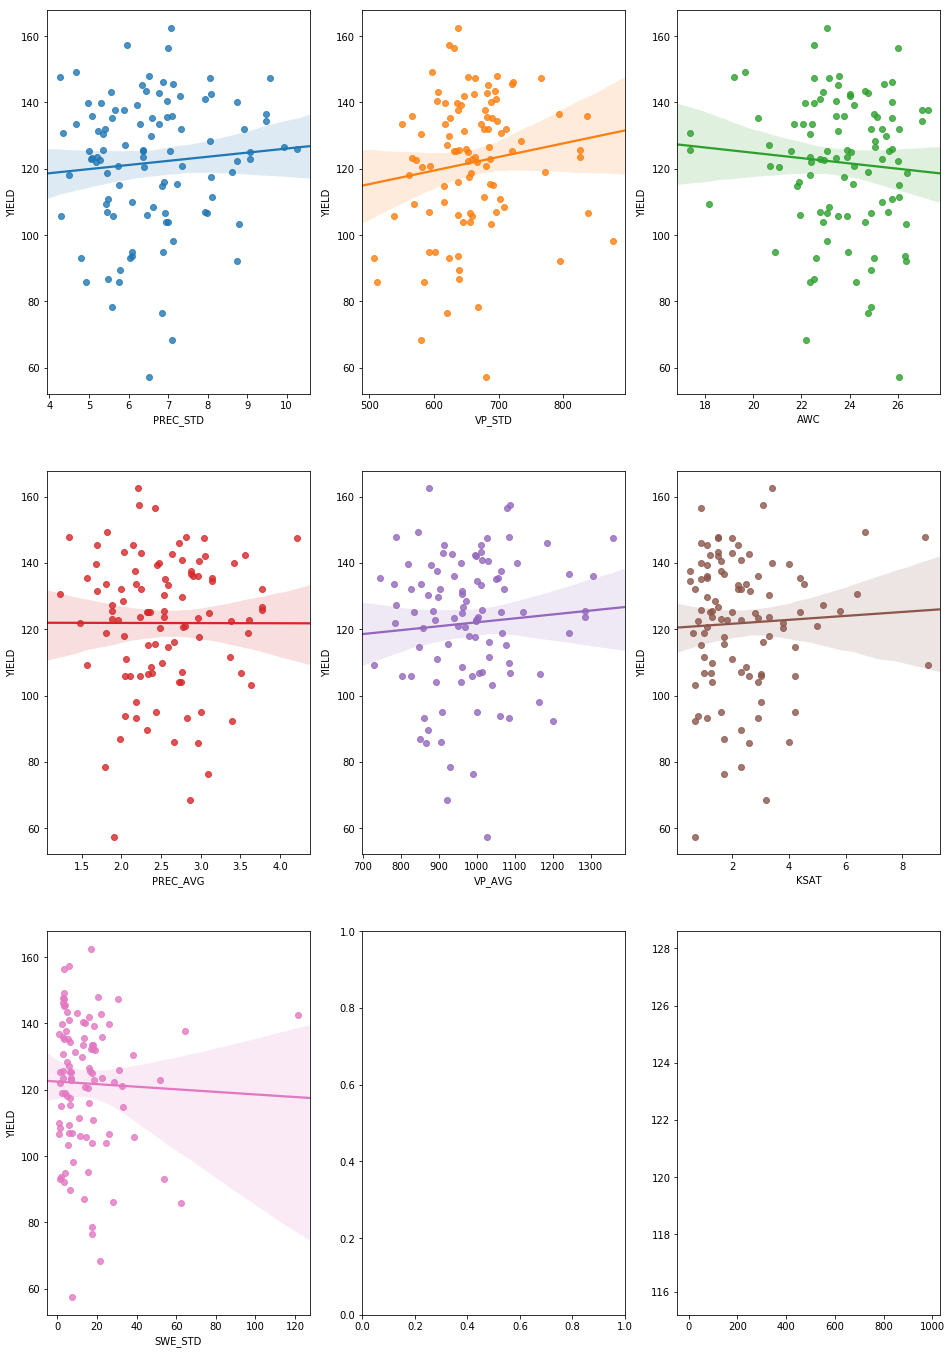

In [22]:
# Correlation between each drought variable and yield
drought_stress_features_list = ['PREC_STD','VP_STD','AWC', 'PREC_AVG','VP_AVG','KSAT','SWE_STD','SWE_AVG']
drought_stress_df_sample = drought_stress_df.sample(100)

fig, ax = plt.subplots(round(len(drought_stress_features_list) / 3), 3, figsize = (16, 24))

for i, ax in enumerate(fig.axes):
    if i < len(drought_stress_features_list) - 1:
        sns.regplot(x=drought_stress_features_list[i],y='YIELD', data=drought_stress_df_sample, ax=ax)

# Exploring categorical variables
- Captures non-numeric variable not featured in the correlation matrices

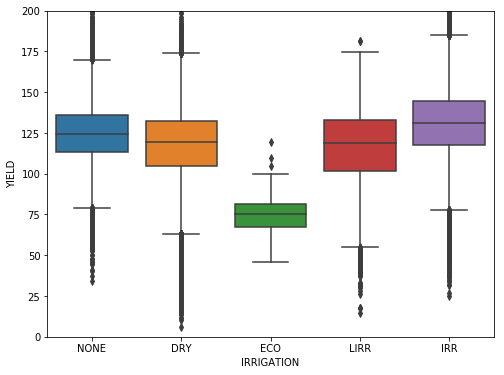

In [23]:
# Ordered from least to most irrigated 
var = 'IRRIGATION'
data = pd.concat([joined_df['YIELD'], joined_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="YIELD", data=data, order=["NONE", "DRY", "ECO","LIRR","IRR"])
fig.axis(ymin=0, ymax=200);

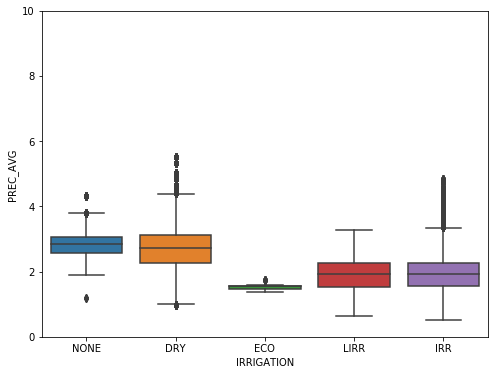

In [24]:
# same for PREC
var = 'IRRIGATION'
data = pd.concat([joined_df['PREC_AVG'], joined_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PREC_AVG", data=data, order=["NONE", "DRY", "ECO","LIRR","IRR"])
fig.axis(ymin=0, ymax=10);

# MACHINE LEARNING

## Transforming weather data into useful metrics



Environmental data will be grouped by ENV_ID. Both averages and standard deviations will be obtained so as to capture the differences in weather. NB: Same average temperatures can hide different extreme environments. 

# HEAT STRESS

In [25]:
#Setting non-numeric variables to index
heat_stress_df = heat_stress_df.set_index(['HYBRID_ID','ENV_ID'])
heat_stress_df.head()

TMAX_AVG   TMAX_STD  TMIN_AVG   TMIN_STD      DAYL_AVG  \
HYBRID_ID ENV_ID                                                           
H2782     Env_1   8.093151  14.926959 -3.256164  13.574307  43200.000043   
          Env_2   8.178082  14.860702 -3.290411  13.446089  43200.000054   
H2240     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   
H1527     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   
H1369     Env_3   9.805479  14.311170 -1.224658  12.901740  43200.000054   

                      DAYL_STD    SRAD_AVG    SRAD_STD     YIELD  
HYBRID_ID ENV_ID                                                  
H2782     Env_1   10075.200862  276.111781  131.085275  107.9577  
          Env_2   10001.326165  278.706849  130.288514   85.7498  
H2240     Env_3   10001.326165  274.112876  122.067104   74.6116  
H1527     Env_3   10001.326165  274.112876  122.067104   83.8191  
H1369     Env_3   10001.326165  274.112876  122.067104   81.7917

In [26]:
print('Total performance observations: ' + str(len(heat_stress_df)))
print('Total unique hybrids: ' + str(len(heat_stress_df.reset_index()['HYBRID_ID'].unique())))

Total performance observations: 387427
Total unique hybrids: 2452


## Setting up a Random Forest model

In [27]:
# Splitting data into training (70%), testing (20%) and validation (10%)
import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(heat_stress_df, test_size = 0.1, random_state=1)
x_train = train.iloc[:,0:-1]
y_train = train['YIELD']
x_test = test.iloc[:,0:-1]
y_test = test['YIELD']


In [28]:
# Setting up model
import numpy as np
from sklearn import linear_model
from sklearn import tree

tree_model_hs = tree.DecisionTreeRegressor()

# Fitting models
tree_model_hs.fit(x_train,y_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Model score

In [29]:
#Get score on the testing data
print('Model score equals: %.3f' % tree_model_hs.score(x_test,y_test))


Model score equals: 0.619


## Understanding the underlying parameters 

A key parameter in the Decision Tree Regressor is the minimum number of instances, i.e. the minimum number of samples required to be at a leaf node. We would expect the model to reduce its MSE to the training data when we decrease the minimum samples required to be a leaf node because more nodes would be added and the data would be more "fit" to the training data. However, with such procedure we would be exposed to an overfitting risk of the model to the training data and hence our MSE to the testing data would increase. 

Surprisingly, the figure below shows this does not apply in our case. The lower the number of instances required in a leaf node, the better for both the training and testing data. We can conclude that having a "super-tree" with as much leafes as number of instances is the best approach for both the training and testing data.


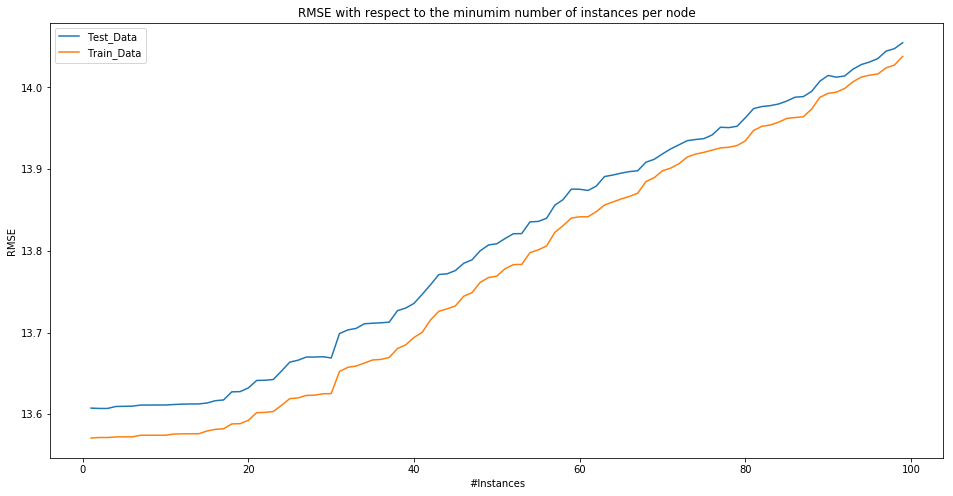

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,8))
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
iterations = 50

for i in range(1,iterations):
    #Parametrize the model and let i be the number of minimum instances per leaf node
    regression_model = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(x_train,y_train)
    #Predict query instances
    predicted_train = regression_model.predict(x_train)
    predicted_test = regression_model.predict(x_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(np.sum(((y_train-predicted_train)**2)/len(y_train))))
    RMSE_test.append(np.sqrt(np.sum(((y_test-predicted_test)**2)/len(y_test))))
    
ax0.plot(range(1,iterations),RMSE_test,label='Test_Data')
ax0.plot(range(1,iterations),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

The same perspective but with model scores (ranging from 0 to 1).


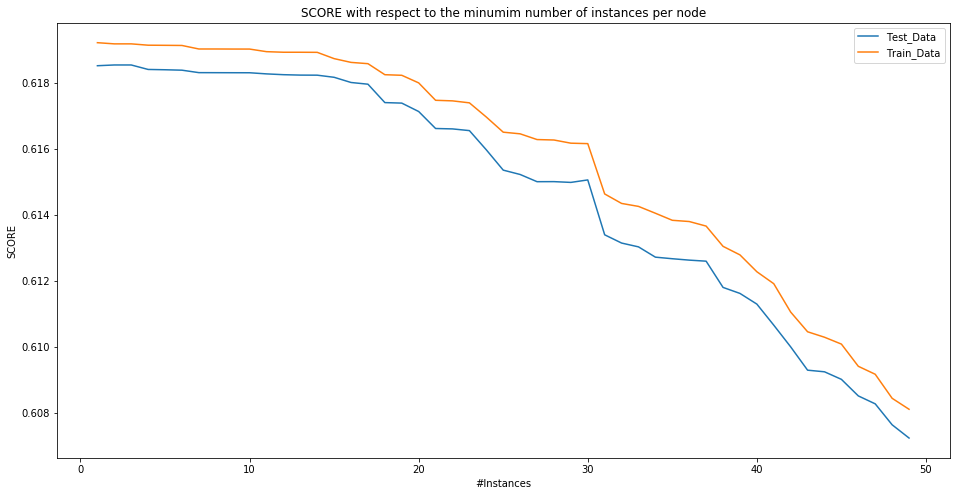

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,8))
ax0 = fig.add_subplot(111) 
SCORE_train = []
SCORE_test = []
iterations = 50

for i in range(1,iterations):
    #Parametrize the model and let i be the number of minimum instances per leaf node
    regression_model = tree.DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(x_train,y_train)
    #Get scores
    SCORE_train.append(regression_model.score(x_train,y_train))
    SCORE_test.append(regression_model.score(x_test,y_test))
        
ax0.plot(range(1,iterations),SCORE_test,label='Test_Data')
ax0.plot(range(1,iterations),SCORE_train,label='Train_Data')
ax0.legend()
ax0.set_title('SCORE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('SCORE')
plt.show()


## Decision Tree illustration


DAYL_STD is the most decisive factor when it comes to predicting yield


In [33]:
import pydotplus 
from IPython.display import Image

feature_names = [key for key in heat_stress_df.columns if not key == 'YIELD']

dot_data = tree.export_graphviz(tree_model_hs,
                                max_depth=2,
                                out_file=None,
                                feature_names=feature_names)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

## Feature importances and individual scores


In [34]:
# Discerning feature importances
tree_model_hs.feature_importances_

# Normalizing dataframe
norm_hs = sklearn.preprocessing.normalize(heat_stress_df,axis=0)
df_hs = pd.DataFrame(norm_hs)
df_hs.describe()
heat_stress_df.describe()
norm_hs

array([[ 0.00082321,  0.00200587, -0.00118195, ...,  0.00138971,
         0.00185695,  0.00141327],
       [ 0.00083185,  0.00199697, -0.00119439, ...,  0.00140277,
         0.00184567,  0.00112254],
       [ 0.00099739,  0.00192312, -0.00044454, ...,  0.00137965,
         0.0017292 ,  0.00097673],
       ...,
       [ 0.00218009,  0.00127003,  0.00374128, ...,  0.00168699,
         0.00142679,  0.00157738],
       [ 0.00218009,  0.00127003,  0.00374128, ...,  0.00168699,
         0.00142679,  0.00176283],
       [ 0.00218009,  0.00127003,  0.00374128, ...,  0.00168699,
         0.00142679,  0.00168785]])

# DROUGHT STRESS


In [35]:
#Setting non-numeric variables to index
drought_stress_df = drought_stress_df.set_index(['HYBRID_ID','ENV_ID'])
drought_stress_df.head()


IRRIGATION  PREC_AVG  PREC_STD  KSAT    SWE_AVG    SWE_STD  \
HYBRID_ID ENV_ID                                                              
H2782     Env_1         DRY  1.684932  4.544882   9.4  11.167123  16.046875   
          Env_2         DRY  1.621918  4.372688  10.2   9.545205  13.847730   
H2240     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   
H1527     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   
H1369     Env_3        NONE  1.183562  4.047351   9.9   4.394521   7.829079   

                      VP_AVG      VP_STD    AWC     YIELD  
HYBRID_ID ENV_ID                                           
H2782     Env_1   630.356164  535.634711  18.65  107.9577  
          Env_2   612.602740  528.588280  18.75   85.7498  
H2240     Env_3   717.917808  585.217198  18.95   74.6116  
H1527     Env_3   717.917808  585.217198  18.95   83.8191  
H1369     Env_3   717.917808  585.217198  18.95   81.7917

### Cleaning data


In [36]:
# Converting irrigation to numeric values
def irrigation_converter(string):
    import numpy as np
    if string == np.nan:
        return np.nan
    if string == 'NONE' or string == 'DRY':
        return 0
    if string == 'ECO':
        return 1
    if string == 'LIRR':
        return 2
    if string == 'IRR':
        return 3
    else:
        next

drought_stress_df['IRRIGATION'] = drought_stress_df['IRRIGATION'].apply(irrigation_converter)
print('Total performance observations: ' + str(len(drought_stress_df)))
print('Total unique hybrids: ' + str(len(drought_stress_df.reset_index()['HYBRID_ID'].unique())))


Total performance observations: 387427
Total unique hybrids: 2452


In [37]:
# Drop nan
drought_stress_df.dropna(inplace=True)

print('Total performance observations: ' + str(len(drought_stress_df)))
print('Total unique hybrids: ' + str(len(drought_stress_df.reset_index()['HYBRID_ID'].unique())))



Total performance observations: 379143
Total unique hybrids: 2452


## Setting up a Random Forest model


In [38]:
# Splitting data
import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(drought_stress_df, test_size = 0.3, random_state=1)
x_train = train.iloc[:,0:-1]
y_train = train['YIELD']
x_test = test.iloc[:,0:-1]
y_test = test['YIELD']

In [39]:
# Setting up model
import numpy as np
from sklearn import linear_model
from sklearn import tree

tree_model_ds = tree.DecisionTreeRegressor()

# Fitting models
tree_model_ds.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Model score

In [40]:
#Get score on the testing data
print(tree_model_ds.score(x_test,y_test))

0.6198836808630228


## Decision Tree illustration


IRRIGATION is the most decisive factor when it comes to predicting yield

In [41]:
import pydotplus 
from IPython.display import Image

feature_names = [key for key in drought_stress_df.columns if not key == 'YIELD']

dot_data = tree.export_graphviz(tree_model_ds,
                                max_depth=2,
                                out_file=None,
                                feature_names=feature_names)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())


ModuleNotFoundError: No module named 'pydotplus'

## Find feature importance